In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import tempfile

# Suppress TensorFlow oneDNN warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [4]:
# Cell 2: Model Initialization

import torch
from transformers import ViTForImageClassification

# Ensure you are working on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model with fine-tuning capability
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', 
    num_labels=2, 
    ignore_mismatched_sizes=True  # To handle uninitialized weights
)

# Move the model to the device (GPU/CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Optional: Print model device to verify
print(f"Model is running on: {device}")

# Optional fine-tuning setup
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir='./logs'
)

trainer = Trainer(
    model=model,
    args=training_args
)

# Optional: Trigger training for fine-tuning (requires dataset)
#trainer.train()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is running on: cpu


In [5]:
def extract_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)
    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    return frames

In [6]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    inputs = image_processor(images=frames, return_tensors="pt")
    outputs = model(**inputs).logits
    preds = torch.argmax(outputs, dim=1).numpy()
    return preds.mean(), preds

In [7]:
def plot_confidence_histogram(preds):
    plt.hist(preds, bins=10, color='blue', alpha=0.7)
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.show()

In [6]:
# Cell 6: Optional Fine-tuning Logic (if user has new datasets)

# Uncomment and implement this cell if you want to fine-tune the model with a custom dataset.
# train_dataset and eval_dataset need to be defined beforehand.
# if fine_tune:
#     trainer.train()
#     trainer.save_model('./vit_retrained_model')
#     print("Model fine-tuned and saved.")

Prediction Score (mean): 0.6


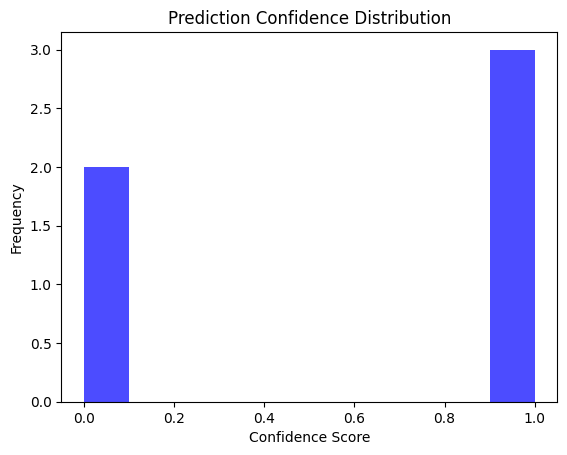

The video is likely **fake**!


In [11]:
video_path =r"C:\Users\arvin\Downloads\download.mp4"

# Predict the video
prediction, preds = predict_video(video_path)
print(f"Prediction Score (mean): {prediction}")

# Visualize the confidence score distribution
plot_confidence_histogram(preds)

# Determine if the video is likely fake or real
if prediction > 0.5:
    print("The video is likely **fake**!")
else:
    print("The video is likely **real**.")

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

y_true, y_pred = evaluate_model(model, test_loader)
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.91      0.98      0.94        51
           1       0.98      0.89      0.93        47

    accuracy                           0.94        98
   macro avg       0.94      0.94      0.94        98
weighted avg       0.94      0.94      0.94        98

Test Accuracy: 0.9388


In [9]:
torch.save(model.state_dict(), 'vit_deepfake_model.pth')
